# Finding Faces in Images with PCA and an ANN (CNNs are scary & I failed at NEAT)

Im not gonna add comments for the imports and installs, but basically just install all the goodies so we can do MATH!

## Installs and Imports

In [1]:
%pip install torch==2.6.0 -f https://download.pytorch.org/whl/torch_stable.html
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
from torch import nn
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import PCA
from PCA import Down, Up

## Ready Data

So, a quick heads up, I used PCA (Principal Component Analysis) to compress my input images from HD color to 256 bytes (64 x f64). The quick summary of what this is doing is trying to find common features in the images and extracting that out into a vector, then the sum of thousands of these features is a total image. If I instead use only the top 64 or so I keep only the 64 most important features and for most images this looks very normal. That could be a project in its own, but thats just preprocessing.

In [ ]:
if not os.path.exists("data.csv"):
    csv = f'fname, label, '+', '.join([f'axis-{i}' for i in range(48)])+'\n'
    for i, fname in list(enumerate(os.listdir('frames/')))[::1]:
        img = cv2.imread(f'frames/{fname}')
        cdi = Down(img) #Down is the custom function I wrote which downscales and greyscales my image and them compresses it.
        tcdi = f', '.join([str(float(x)) for x in cdi])
        csv += f'{fname}, {fname.split('-')[0]}, {tcdi}\n'
    with open('data.csv', 'w') as f:
        f.write(csv)
    del csv

If our data isnt ready we build it regardless-then we just slap it all in a big table so we can inspect it.

In [6]:
frame = pd.read_csv('data.csv')
frame

,fname,label,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,...,axis-38,axis-39,axis-40,axis-41,axis-42,axis-43,axis-44,axis-45,axis-46,axis-47
0,face-0.jpg,face,873.389620,-1550.315621,-2842.408198,-14705.157029,8760.951791,4934.974152,2634.410305,3852.926839,...,5363.728416,-2560.751908,-4904.454853,2496.613446,449.581077,1786.186591,-1236.533003,2723.883527,2605.336967,1982.943972
1,face-1.jpg,face,5169.017590,-3255.437787,341.602292,-415.363938,-4224.572145,2731.658505,223.092115,5826.850294,...,367.527043,1100.701145,-215.812467,3024.572959,-645.545601,2205.246509,-76.041792,-3893.266282,-1536.946769,550.900611
2,face-10.jpg,face,-2401.699552,7605.337467,-8173.930962,10497.442953,-476.277798,-883.530099,-7852.850712,-664.478038,...,1138.617779,4436.789319,-1232.261533,-1736.734798,-4006.543014,-3.441193,1255.247101,-4668.286227,1882.795103,-3184.043283
3,face-11.jpg,face,16039.883204,16474.704246,6630.149901,2135.684085,2650.182707,15154.950164,-7554.902103,3378.151245,...,2686.596300,-3583.895631,-881.265141,-676.567028,3272.930264,1692.142708,-2129.315270,-15.495004,3241.385845,-3092.012070
4,face-12.jpg,face,4259.660750,11374.123884,-725.270798,7119.964925,1107.691732,-2533.687081,-133.029412,213.393975,...,3100.596065,2327.170000,-1348.730535,2798.773880,-63.655506,1103.584470,153.224463,2106.791412,-1405.081807,-520.437681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,nonface-65.jpg,nonface,8583.278011,-7085.828618,3855.841895,-8784.232844,-4641.406205,-3309.116975,-5872.362348,4678.591236,...,-4790.481610,2893.073183,4677.805766,5745.170040,1885.096257,-5459.408755,-184.873013,5961.920456,162.728404,-974.335562
128,nonface-66.jpg,nonface,-4415.607880,5869.365103,-284.878223,4189.213340,8035.093980,-5650.606754,-2013.298161,3460.627595,...,-1731.757078,-4646.671942,2318.958780,2588.096382,1526.482734,751.421336,644.569575,-710.256920,2236.031953,5593.701648
129,nonface-7.jpg,nonface,-41370.810516,-12472.848370,-3815.385177,-2437.675397,2231.762672,-4423.278977,3335.584902,1599.292662,...,-693.095697,-1371.837966,-1615.755248,2236.030081,-1450.827839,332.667686,573.289906,2576.419912,1730.928059,-3143.705999
130,nonface-8.jpg,nonface,6222.958417,-1361.226434,9574.750671,-7979.242136,-4876.445727,2027.706900,-2672.536052,5396.917236,...,2058.485406,-547.126167,-807.991815,1074.056830,-864.610153,-4171.227624,2113.073927,-3966.594685,-363.442898,2663.182385


As we can now see, we have a bunch of pictures with faces and a bunch w/o (abt 60 ea.), and a bunch of unintuitive "axis" which correspond to abstract features of our image.

We're gonna go ahead and add row information and make a boolean face value for the AI to learn.

In [7]:
frame['row'] = range(len(frame))
frame['isFace'] = frame['label'] == 'face'

Next we'll extract out the numeric values so we can easier convert this to an AI friendly format while being able to convert back with row info.

In [8]:
numframe = frame[['row']+['isFace']+[f'axis-{i}' for i in range(48)]]
numframe

,row,isFace,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,...,axis-38,axis-39,axis-40,axis-41,axis-42,axis-43,axis-44,axis-45,axis-46,axis-47
0,0,True,873.389620,-1550.315621,-2842.408198,-14705.157029,8760.951791,4934.974152,2634.410305,3852.926839,...,5363.728416,-2560.751908,-4904.454853,2496.613446,449.581077,1786.186591,-1236.533003,2723.883527,2605.336967,1982.943972
1,1,True,5169.017590,-3255.437787,341.602292,-415.363938,-4224.572145,2731.658505,223.092115,5826.850294,...,367.527043,1100.701145,-215.812467,3024.572959,-645.545601,2205.246509,-76.041792,-3893.266282,-1536.946769,550.900611
2,2,True,-2401.699552,7605.337467,-8173.930962,10497.442953,-476.277798,-883.530099,-7852.850712,-664.478038,...,1138.617779,4436.789319,-1232.261533,-1736.734798,-4006.543014,-3.441193,1255.247101,-4668.286227,1882.795103,-3184.043283
3,3,True,16039.883204,16474.704246,6630.149901,2135.684085,2650.182707,15154.950164,-7554.902103,3378.151245,...,2686.596300,-3583.895631,-881.265141,-676.567028,3272.930264,1692.142708,-2129.315270,-15.495004,3241.385845,-3092.012070
4,4,True,4259.660750,11374.123884,-725.270798,7119.964925,1107.691732,-2533.687081,-133.029412,213.393975,...,3100.596065,2327.170000,-1348.730535,2798.773880,-63.655506,1103.584470,153.224463,2106.791412,-1405.081807,-520.437681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,127,False,8583.278011,-7085.828618,3855.841895,-8784.232844,-4641.406205,-3309.116975,-5872.362348,4678.591236,...,-4790.481610,2893.073183,4677.805766,5745.170040,1885.096257,-5459.408755,-184.873013,5961.920456,162.728404,-974.335562
128,128,False,-4415.607880,5869.365103,-284.878223,4189.213340,8035.093980,-5650.606754,-2013.298161,3460.627595,...,-1731.757078,-4646.671942,2318.958780,2588.096382,1526.482734,751.421336,644.569575,-710.256920,2236.031953,5593.701648
129,129,False,-41370.810516,-12472.848370,-3815.385177,-2437.675397,2231.762672,-4423.278977,3335.584902,1599.292662,...,-693.095697,-1371.837966,-1615.755248,2236.030081,-1450.827839,332.667686,573.289906,2576.419912,1730.928059,-3143.705999
130,130,False,6222.958417,-1361.226434,9574.750671,-7979.242136,-4876.445727,2027.706900,-2672.536052,5396.917236,...,2058.485406,-547.126167,-807.991815,1074.056830,-864.610153,-4171.227624,2113.073927,-3966.594685,-363.442898,2663.182385


To make sure our model doesnt explode and die, we'll normalize our data by subtracting the mean and dividing off the standard deviation (or 1 if its 0). We also will save this for later so we can use this to test data out of sample.

In [9]:
nfstd = numframe.std()
nfstd += nfstd == 0
nfstd[:2] = 1
nfavg = numframe.mean()
nfavg[:2] = 0
numframe = (numframe-nfavg)/nfstd
numframe

,row,isFace,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,...,axis-38,axis-39,axis-40,axis-41,axis-42,axis-43,axis-44,axis-45,axis-46,axis-47
0,0.0,1.0,0.049634,-0.165314,-0.364002,-2.146359,1.318966,0.800739,0.480210,0.768057,...,2.311836,-1.116617,-2.151926,1.103033,0.201308,0.806626,-0.567268,1.265377,1.245847,0.956804
1,1.0,1.0,0.293751,-0.347135,0.043746,-0.060626,-0.636011,0.443233,0.040666,1.161546,...,0.158409,0.479961,-0.094692,1.336292,-0.289055,0.995870,-0.034885,-1.808612,-0.734953,0.265819
2,2.0,1.0,-0.136487,0.810976,-1.046762,1.532203,-0.071704,-0.143360,-1.431447,-0.132459,...,0.490759,1.934664,-0.540679,-0.767310,-1.794001,-0.001554,0.575853,-2.168647,0.900334,-1.536355
3,3.0,1.0,0.911535,1.756739,0.849064,0.311724,0.398986,2.459012,-1.377136,0.673413,...,1.157957,-1.562759,-0.386672,-0.298915,1.465513,0.764156,-0.976837,-0.007198,1.549999,-1.491948
4,4.0,1.0,0.242073,1.212851,-0.092879,1.039227,0.166764,-0.411111,-0.024249,0.042539,...,1.336397,1.014763,-0.591782,1.236532,-0.028503,0.498369,0.070293,0.978708,-0.671896,-0.251120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,127.0,0.0,0.487781,-0.755580,0.493783,-1.282143,-0.698766,-0.536931,-1.070436,0.932648,...,-2.064759,1.261526,2.052479,2.538284,0.844086,-2.465420,-0.084812,2.769603,0.077815,-0.470133
128,128.0,0.0,-0.250936,0.625865,-0.036482,0.611456,1.209687,-0.916856,-0.366992,0.689854,...,-0.746410,-2.026183,1.017489,1.143452,0.683510,0.339335,0.295701,-0.329949,1.069249,2.699056
129,129.0,0.0,-2.351072,-1.330011,-0.488602,-0.355802,0.335993,-0.717712,0.608023,0.318809,...,-0.298733,-0.598190,-0.708944,0.987905,-0.649634,0.150230,0.263001,1.196873,0.827713,-1.516891
130,130.0,0.0,0.353646,-0.145151,1.226153,-1.164647,-0.734151,0.329012,-0.487160,1.075841,...,0.887234,-0.238575,-0.354522,0.474531,-0.387145,-1.883689,0.969387,-1.842677,-0.173795,1.285031


In [10]:
npframe = numframe.to_numpy().astype(np.float64)
tnsframe = torch.from_numpy(npframe)
tnsframe.shape

torch.Size([132, 50])

## Linear Model

For our first simple model, I'll just a simple fully connected ANN w/o an activation layer.

In [ ]:
linear = torch.nn.Linear(in_features=48, # in_features: must match column number of input
                         out_features=1,# out_features: column number of output
                         dtype=torch.float64) #specifies the data type, MUST match orelse it cries

This code below just sets up our frame data and I used slice notation so I didnt need to unsqueeze it.

In [12]:
X = tnsframe[:,2:2+48]
print(f'{X.shape=}')
y = tnsframe[:,1:1+1]
print(f'{y.shape=}')

# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.shape=torch.Size([132, 48])
y.shape=torch.Size([132, 1])


Ctrl+C Ctrl-V, we have a loss function now

In [13]:
loss_fn = nn.MSELoss() # mean squared error; this is similar to multiplying our matrix by itself

# Create an optimizer; SGD is stochastic gradient decent
optimizer = torch.optim.SGD(params=linear.parameters(),
                            lr=0.1) #this is how fast it optimizes; smaller is slower, but more consistent

And this code below will iteratively train our model via forwards and backwards passes

In [14]:
# Set the number of epochs; this is how many times we update our model
epochs = 100

with torch.autograd.detect_anomaly(True):
  for epoch in range(epochs):
      ### Training

      #this allows our matrices to update
      linear.train()

      # 1. Forward pass; makes predictions
      y_pred = linear(X_train)

      # 2. Calculate loss; how bad were our predictions?
      loss = loss_fn(y_pred, y_train)

      # 3. Optimizer zero grad; resets how we change our model
      optimizer.zero_grad()

      # 4. Loss backwards; determines how to change our weights matrix
      loss.backward()

      # 5. Optimizer step; changes our weights matrix based on .backward()
      optimizer.step()

      ### Testing
      linear.eval() #forces our matrices to stay the same
      with torch.inference_mode():
        # 1. Forward pass; makes predictions, but with test data
        test_pred = linear(X_test)
        # 2. Calculate the loss, but with test data
        test_loss = loss_fn(test_pred, y_test)

      # Print out what's happening
      if epoch % 10 == 0: #prints every 100 epochs
          print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

C:\Users\gbell\AppData\Local\Temp\ipykernel_19112\3510075855.py:4: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly(True):


Epoch: 0 | Train loss: 0.71771, Test loss: 0.68353
Epoch: 10 | Train loss: 0.09344, Test loss: 0.29655
Epoch: 20 | Train loss: 0.07866, Test loss: 0.34977
Epoch: 30 | Train loss: 0.07602, Test loss: 0.42286
Epoch: 40 | Train loss: 0.07502, Test loss: 0.48278
Epoch: 50 | Train loss: 0.07454, Test loss: 0.52851
Epoch: 60 | Train loss: 0.07430, Test loss: 0.56261
Epoch: 70 | Train loss: 0.07418, Test loss: 0.58770
Epoch: 80 | Train loss: 0.07412, Test loss: 0.60603
Epoch: 90 | Train loss: 0.07408, Test loss: 0.61934


Ok, so a `0.074` train vs `0.619` test is pretty bad, thats about 10x, so its probably overfitting alot and the rapid decrease makes me think memorization

## Future Models

Now to speed up building models I abstracted the loss functions and training code into a function so I can just call it after declaring a model

In [ ]:
def TrainAndLog(model, lr: float = .1, epochs: int = 10_000, printevery: int = 100) -> None:
    loss_fn = nn.MSELoss()
    # Create an optimizer; SGD is stochastic gradient decent
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    # Set the number of epochs; this is how many times we update our model
    epochs = 10_000
    for epoch in range(epochs):
        ### Training

        #this allows our matrices to update
        model.train()

        # 1. Forward pass; makes predictions
        y_pred = model(X_train)

        # 2. Calculate loss; how bad were our predictions?
        loss = loss_fn(y_pred, y_train)

        # 3. Optimizer zero grad; resets how we change our model
        optimizer.zero_grad()

        # 4. Loss backwards; determines how to change our weights matrix
        loss.backward()

        # 5. Optimizer step; changes our weights matrix based on .backward()
        optimizer.step()

        ### Testing
        model.eval() #forces our matrices to stay the same
        with torch.inference_mode():
        # 1. Forward pass; makes predictions, but with test data
            test_pred = model(X_test)
            # 2. Calculate the loss, but with test data
            test_loss = loss_fn(test_pred, y_test)

        # Print out what's happening
        if epoch % printevery == 0: #prints every `printevery` epochs
            print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

## Various Models

Ok so here's the sad part. I didnt save and I lost 4 more models. However they did prompt me to talk to Mr. Arredondo and he sugguested a Dropout layer to fix overfitting. In short it will occasionally (50%) of the time set a node to 0 going in so that the model can't rely on memorizing an input as there will be some volatility in its structure. Theoretically this means it has to learn redundantly the underlying patterns.

In [16]:
model_0 = nn.Sequential( 
    nn.Linear(48, 10, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(),
    nn.Linear(10, 1, dtype = torch.float64),
    nn.Tanh(),
)

curr_model = model_0

So I simply decided on two layers, Tanh and a dropout in the middle

In [17]:
TrainAndLog(model_0)

Epoch: 0 | Train loss: 0.92922, Test loss: 0.69339
Epoch: 100 | Train loss: 0.10306, Test loss: 0.22685
Epoch: 200 | Train loss: 0.09672, Test loss: 0.31274
Epoch: 300 | Train loss: 0.10086, Test loss: 0.36099
Epoch: 400 | Train loss: 0.09503, Test loss: 0.38907
Epoch: 500 | Train loss: 0.08293, Test loss: 0.40535
Epoch: 600 | Train loss: 0.07822, Test loss: 0.41821
Epoch: 700 | Train loss: 0.07586, Test loss: 0.43063
Epoch: 800 | Train loss: 0.07583, Test loss: 0.43905
Epoch: 900 | Train loss: 0.07351, Test loss: 0.43515
Epoch: 1000 | Train loss: 0.06749, Test loss: 0.44303
Epoch: 1100 | Train loss: 0.06424, Test loss: 0.43965
Epoch: 1200 | Train loss: 0.07865, Test loss: 0.43968
Epoch: 1300 | Train loss: 0.06113, Test loss: 0.44927
Epoch: 1400 | Train loss: 0.06451, Test loss: 0.44677
Epoch: 1500 | Train loss: 0.05581, Test loss: 0.44780
Epoch: 1600 | Train loss: 0.06470, Test loss: 0.44102
Epoch: 1700 | Train loss: 0.06754, Test loss: 0.44029
Epoch: 1800 | Train loss: 0.06652, Test 

And thats looking somewhat better, but also not at all. The Test loss has actually INCREASED (from the 100th epoch)! eek, and out training loss isnt doing too great, but it has actually generally improved, so we got past some local minima last time.

In [18]:
model_1 = nn.Sequential( 
    nn.Linear(48, 16, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(),
    nn.Linear(16, 8, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(),
    nn.Linear(8, 4, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(),
    nn.Linear(4, 1, dtype = torch.float64),
    nn.Sigmoid(),
)

So obviously more layers is better. I just amplified it using a 48 -> 16 -> 8 -> 4 -> 1 structure and switched the activation function at the end to sigmoid since our output is 0-1 (face or not face)

In [19]:
TrainAndLog(model_1)

Epoch: 0 | Train loss: 0.26142, Test loss: 0.25123
Epoch: 100 | Train loss: 0.24106, Test loss: 0.24691
Epoch: 200 | Train loss: 0.20539, Test loss: 0.22499
Epoch: 300 | Train loss: 0.15305, Test loss: 0.18598
Epoch: 400 | Train loss: 0.11827, Test loss: 0.16578
Epoch: 500 | Train loss: 0.08682, Test loss: 0.15482
Epoch: 600 | Train loss: 0.10130, Test loss: 0.14953
Epoch: 700 | Train loss: 0.06810, Test loss: 0.14753
Epoch: 800 | Train loss: 0.07447, Test loss: 0.15000
Epoch: 900 | Train loss: 0.08290, Test loss: 0.14773
Epoch: 1000 | Train loss: 0.09383, Test loss: 0.14789
Epoch: 1100 | Train loss: 0.04663, Test loss: 0.14663
Epoch: 1200 | Train loss: 0.05197, Test loss: 0.14632
Epoch: 1300 | Train loss: 0.05259, Test loss: 0.14641
Epoch: 1400 | Train loss: 0.05887, Test loss: 0.14622
Epoch: 1500 | Train loss: 0.04977, Test loss: 0.14677
Epoch: 1600 | Train loss: 0.04867, Test loss: 0.14629
Epoch: 1700 | Train loss: 0.04152, Test loss: 0.14920
Epoch: 1800 | Train loss: 0.04099, Test 

Better again! We're making progress, I like this, Train loss is again lower and Test loss isnt horrendous now, its a mere `.184` which is far better

In [20]:
model_2 = nn.Sequential( 
    nn.Dropout(p=.7),
    nn.Linear(48, 8, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.7),
    nn.Linear(8, 1, dtype = torch.float64),
    nn.Sigmoid(),
)

Now wait a second, what if input vectors could be droped out, then it cant rely on memorizing a single feature via redundant nodes, maybe now itll learn collections of inputs?

In [21]:
TrainAndLog(model_2)

Epoch: 0 | Train loss: 0.28143, Test loss: 0.25288
Epoch: 100 | Train loss: 0.25237, Test loss: 0.23287
Epoch: 200 | Train loss: 0.22961, Test loss: 0.22206
Epoch: 300 | Train loss: 0.22858, Test loss: 0.21806
Epoch: 400 | Train loss: 0.22182, Test loss: 0.20627
Epoch: 500 | Train loss: 0.22485, Test loss: 0.20229
Epoch: 600 | Train loss: 0.22813, Test loss: 0.20314
Epoch: 700 | Train loss: 0.18760, Test loss: 0.20110
Epoch: 800 | Train loss: 0.22900, Test loss: 0.19954
Epoch: 900 | Train loss: 0.22013, Test loss: 0.20254
Epoch: 1000 | Train loss: 0.23456, Test loss: 0.20089
Epoch: 1100 | Train loss: 0.20358, Test loss: 0.20114
Epoch: 1200 | Train loss: 0.19051, Test loss: 0.20298
Epoch: 1300 | Train loss: 0.23682, Test loss: 0.20805
Epoch: 1400 | Train loss: 0.20802, Test loss: 0.20562
Epoch: 1500 | Train loss: 0.20493, Test loss: 0.20707
Epoch: 1600 | Train loss: 0.21148, Test loss: 0.20713
Epoch: 1700 | Train loss: 0.19732, Test loss: 0.20755
Epoch: 1800 | Train loss: 0.19904, Test 

Ok so not really. Again we have pretty good Test loss for as simple as our model is, but out Training loss is just as bad as our test loss, so victories and failures.

In [22]:
model_3 = nn.Sequential( 
    nn.Dropout(p=.7),
    nn.Linear(48, 6, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.2),
    nn.Linear(6, 6, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.2),
    nn.Linear(6, 6, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.2),
    nn.Linear(6, 6, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.2),
    nn.Linear(6, 1, dtype = torch.float64),
    nn.Sigmoid(),
)

TrainAndLog(model_3)

Epoch: 0 | Train loss: 0.25735, Test loss: 0.24766
Epoch: 100 | Train loss: 0.24446, Test loss: 0.24999
Epoch: 200 | Train loss: 0.24690, Test loss: 0.24814
Epoch: 300 | Train loss: 0.24983, Test loss: 0.24306
Epoch: 400 | Train loss: 0.24592, Test loss: 0.23384
Epoch: 500 | Train loss: 0.23787, Test loss: 0.21685
Epoch: 600 | Train loss: 0.23111, Test loss: 0.19877
Epoch: 700 | Train loss: 0.21866, Test loss: 0.19525
Epoch: 800 | Train loss: 0.21554, Test loss: 0.19539
Epoch: 900 | Train loss: 0.20567, Test loss: 0.19856
Epoch: 1000 | Train loss: 0.20920, Test loss: 0.20221
Epoch: 1100 | Train loss: 0.19073, Test loss: 0.20737
Epoch: 1200 | Train loss: 0.18680, Test loss: 0.20935
Epoch: 1300 | Train loss: 0.19996, Test loss: 0.20373
Epoch: 1400 | Train loss: 0.20710, Test loss: 0.20169
Epoch: 1500 | Train loss: 0.20309, Test loss: 0.20075
Epoch: 1600 | Train loss: 0.16290, Test loss: 0.20076
Epoch: 1700 | Train loss: 0.19995, Test loss: 0.20568
Epoch: 1800 | Train loss: 0.21404, Test 

Now lets just amp that model up and turn down the internal dropout rate because Im worried with as small as it is that the chance all meaningfull data gets lost is too high.

And again out loss is really struggling. I expected dropout on input to do well, but it doesnt seem to be. :\

In [23]:
model_4 = nn.Sequential( 
    nn.Dropout(p=.7),
    nn.Linear(48, 6, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.5),
    nn.Linear(6, 5, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.4),
    nn.Linear(5, 4, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.3),
    nn.Linear(4, 3, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.2),
    nn.Linear(3, 1, dtype = torch.float64),
    nn.Sigmoid(),
)

TrainAndLog(model_4)

Epoch: 0 | Train loss: 0.27245, Test loss: 0.24859
Epoch: 100 | Train loss: 0.24413, Test loss: 0.24839
Epoch: 200 | Train loss: 0.24461, Test loss: 0.24747
Epoch: 300 | Train loss: 0.24243, Test loss: 0.24348
Epoch: 400 | Train loss: 0.23196, Test loss: 0.23731
Epoch: 500 | Train loss: 0.21697, Test loss: 0.22852
Epoch: 600 | Train loss: 0.23382, Test loss: 0.21665
Epoch: 700 | Train loss: 0.24504, Test loss: 0.20957
Epoch: 800 | Train loss: 0.21476, Test loss: 0.20119
Epoch: 900 | Train loss: 0.22564, Test loss: 0.20174
Epoch: 1000 | Train loss: 0.22327, Test loss: 0.19956
Epoch: 1100 | Train loss: 0.23501, Test loss: 0.19933
Epoch: 1200 | Train loss: 0.22253, Test loss: 0.19721
Epoch: 1300 | Train loss: 0.20287, Test loss: 0.19721
Epoch: 1400 | Train loss: 0.19660, Test loss: 0.20046
Epoch: 1500 | Train loss: 0.19741, Test loss: 0.19778
Epoch: 1600 | Train loss: 0.22431, Test loss: 0.20284
Epoch: 1700 | Train loss: 0.23593, Test loss: 0.20832
Epoch: 1800 | Train loss: 0.22070, Test 

Maybe what if we slowly squeeze the space down rather than a long tube?

Slightly worse. Hmmmmmmmmmmm

In [24]:
model_5 = nn.Sequential( 
    nn.Dropout(p=.8),
    nn.Linear(48, 48, dtype = torch.float64),
    nn.Tanh(),
    nn.Dropout(p=.8),
    nn.Linear(48, 1, dtype = torch.float64),
    nn.Sigmoid(),
)

TrainAndLog(model_5)

Epoch: 0 | Train loss: 0.30862, Test loss: 0.29038
Epoch: 100 | Train loss: 0.25057, Test loss: 0.25218
Epoch: 200 | Train loss: 0.22871, Test loss: 0.24019
Epoch: 300 | Train loss: 0.24248, Test loss: 0.23742
Epoch: 400 | Train loss: 0.25833, Test loss: 0.23655
Epoch: 500 | Train loss: 0.21480, Test loss: 0.23183
Epoch: 600 | Train loss: 0.23204, Test loss: 0.22450
Epoch: 700 | Train loss: 0.25920, Test loss: 0.22628
Epoch: 800 | Train loss: 0.22362, Test loss: 0.22564
Epoch: 900 | Train loss: 0.24706, Test loss: 0.22050
Epoch: 1000 | Train loss: 0.22269, Test loss: 0.21707
Epoch: 1100 | Train loss: 0.23179, Test loss: 0.21566
Epoch: 1200 | Train loss: 0.22772, Test loss: 0.21651
Epoch: 1300 | Train loss: 0.23006, Test loss: 0.21653
Epoch: 1400 | Train loss: 0.21636, Test loss: 0.21312
Epoch: 1500 | Train loss: 0.23552, Test loss: 0.21613
Epoch: 1600 | Train loss: 0.20453, Test loss: 0.21163
Epoch: 1700 | Train loss: 0.22664, Test loss: 0.21781
Epoch: 1800 | Train loss: 0.22886, Test 

Alright maybe since the narrow space did worse, lets give it a massive square of nodes, a 48 -> 48 -> 1

And again, really bad. Ive got a feeling that dropout on our inputs level the playing field too much and secretly sabotage our model.

Now Imma just write some code to help find the filenames of our vectors so we can get the raw images to vibe check the models themselves

In [25]:
def FindFNameByMCDI(mcdi):
    bools = (numframe[[f'axis-{i}' for i in range(48)]] == mcdi).to_numpy()
    rows = np.all(bools, 1)
    idx = int(np.nonzero(rows)[0][0])
    fname = os.listdir('frames/')[idx]
    return fname, idx

We can just get the test vectors themselves and then use this function to find the filenames. `X_test[13]` is for example `nonface-16.jpg`

In [26]:
x0 = X_test[13]
FindFNameByMCDI(x0)

('nonface-16.jpg', 73)

So we can just either random sample or get that image

In [27]:
randimg = np.random.choice(os.listdir('frames/'))
randimg, _ = FindFNameByMCDI(x0)
randimg

'nonface-16.jpg'

And then extract out the features from said image and compress it into its Core DImensions (CDI), then decompress it to get a "feel" for what the AIs seeing.

In [28]:
img = cv2.imread(f'frames/{randimg}')
cdi = Down(img)
mcdi = ((cdi - nfavg[2:]) / nfstd[2:]).to_numpy()
recimg = Up(cdi)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15197328817748945..1.0].


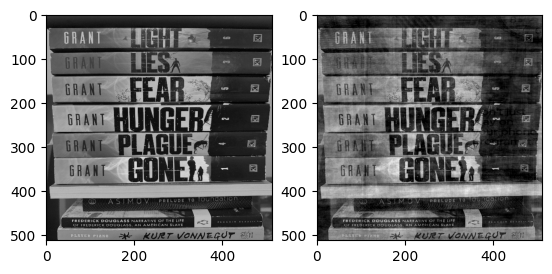

In [29]:
plts, f = plt.subplots(1, 2)
f[0].imshow(img)
f[1].imshow(np.clip(0,1, recimg/255))

For Xtest-13, the reconstraucted image looks very good, but a fair number reconstruct to meaningless grey, so I dont judge it for failing there.

Now I pay the consequence of not putting my models in dict or list to begin with and manually so I can procedurally get then

In [30]:
models = {'linear': linear, 'model_0': model_0, 'model_1': model_1, 'model_2': model_2, 'model_3': model_3, 'model_4': model_4, 'model_5': model_5}

Here I just wrote a function to get the collectively chosen guess

In [31]:
def DemGuess(mcdi):
    faces = 0
    for mod in models.values():
        pred = mod(torch.from_numpy(mcdi))
        faces += pred>.5
    return float(faces) / len(models)

This just shows all of the model's predictions!

In [32]:
for modname, mod in models.items():
    pred = mod(torch.from_numpy(mcdi))
    guess = ['Non-Face', 'Face'][pred > .5]
    print(f'{modname.ljust(10)} predicted {guess.ljust(8)} ({2*float(pred)-1:+.3f}).\t Is `{randimg.split("-")[0]}`')

linear     predicted Face     (+4.662).	 Is `nonface`
model_0    predicted Face     (+0.758).	 Is `nonface`
model_1    predicted Face     (+0.998).	 Is `nonface`
model_2    predicted Face     (+0.430).	 Is `nonface`
model_3    predicted Face     (+0.166).	 Is `nonface`
model_4    predicted Face     (+0.504).	 Is `nonface`
model_5    predicted Face     (+0.320).	 Is `nonface`


In [54]:
succ = {'Dem': 0}
for modname in models:
    succ[modname] = 0
gs = {}
sc = {}

for x in X_test:
    fname, _ = FindFNameByMCDI(x)
    for modname, mod in models.items():
        pred = mod(x)
        rg = (fname == 'face')
        bg = int(pred > .5)
        guess = bg ^ rg
        succ[modname] += guess
    pred = DemGuess(x.cpu().detach().numpy())
    guess = int(pred > .5) ^ (fname == 'face')
    succ['Dem'] += guess

#succ, len(X_test)
sl = sorted([(m, v) for m, v in succ.items()], key = lambda x: x[1])[::-1]
for m, v in sl:
    print(f'{m}:'.ljust(10)+ f' {v}/{len(X_test)}')

model_0:   16/27
model_4:   12/27
model_1:   12/27
linear:    12/27
model_3:   10/27
model_2:   10/27
Dem:       10/27
model_5:   9/27


As we can see, wisdom of the crowds does not apply to our models, the Democratic model does the 2nd worst, only outperformed by the most recent model. Interestingly we can see our first nonlinear model wins by a large amount, scoring `59.25%` Thats like really bad. Its barely better than random guessing and its disapointing to realize ALL OTHER MODELS DO WORSE. My worst model is wrong more often than right in a 50/50 game. Slow clap.

Below I included some stuff about CNNs, but I couldnt get them to work :((((. So very sadge

## Conclusion!

 - PCA is nice to reducing the complexity of your data
 - BUT! it annihliatates data locality, so moving an object around will radically alter the AIs response
 - CNNs can fix this because they dont depend on an absolute location
 - Dropout layers can fix overfitting, but if your data has too many features and too little inputs itll be hard to learn in the first place

## CNNs Begin

In [34]:
import pickle as pk

In [35]:
cols = ['fname', 'label'] + [f'axis-{i}' for i in range(512*512)]

In [36]:
framefull = pd.DataFrame(columns = cols)
framefull

,fname,label,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,...,axis-262134,axis-262135,axis-262136,axis-262137,axis-262138,axis-262139,axis-262140,axis-262141,axis-262142,axis-262143


In [37]:
list(zip(cols, list(img[:,:,0].flatten())))

[('fname', np.uint8(64)),
 ('label', np.uint8(65)),
 ('axis-0', np.uint8(65)),
 ('axis-1', np.uint8(63)),
 ('axis-2', np.uint8(63)),
 ('axis-3', np.uint8(65)),
 ('axis-4', np.uint8(63)),
 ('axis-5', np.uint8(60)),
 ('axis-6', np.uint8(63)),
 ('axis-7', np.uint8(64)),
 ('axis-8', np.uint8(63)),
 ('axis-9', np.uint8(63)),
 ('axis-10', np.uint8(64)),
 ('axis-11', np.uint8(63)),
 ('axis-12', np.uint8(62)),
 ('axis-13', np.uint8(63)),
 ('axis-14', np.uint8(59)),
 ('axis-15', np.uint8(61)),
 ('axis-16', np.uint8(64)),
 ('axis-17', np.uint8(65)),
 ('axis-18', np.uint8(64)),
 ('axis-19', np.uint8(64)),
 ('axis-20', np.uint8(64)),
 ('axis-21', np.uint8(66)),
 ('axis-22', np.uint8(64)),
 ('axis-23', np.uint8(65)),
 ('axis-24', np.uint8(64)),
 ('axis-25', np.uint8(67)),
 ('axis-26', np.uint8(66)),
 ('axis-27', np.uint8(69)),
 ('axis-28', np.uint8(66)),
 ('axis-29', np.uint8(65)),
 ('axis-30', np.uint8(64)),
 ('axis-31', np.uint8(63)),
 ('axis-32', np.uint8(63)),
 ('axis-33', np.uint8(63)),
 ('axi

In [38]:
for i, fname in list(enumerate(os.listdir('frames/')))[::1]:
    img = cv2.imread(f'frames/{fname}')
    #d = pd.DataFrame({k:c for k,c in zip(cols, [fname, fname.split('-')[1]]+list(img[:,:,0].flatten()))})
    #framefull = pd.concat([framefull, d])
    framefull.loc[i] = [fname, fname.split('-')[1]]+list(img[:,:,0].flatten())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


In [39]:
framefull

,fname,label,axis-0,axis-1,axis-2,axis-3,axis-4,axis-5,axis-6,axis-7,...,axis-262134,axis-262135,axis-262136,axis-262137,axis-262138,axis-262139,axis-262140,axis-262141,axis-262142,axis-262143
0,face-0.jpg,0.jpg,205,199,200,201,198,154,83,92,...,144,140,143,144,140,139,144,137,139,138
1,face-1.jpg,1.jpg,203,198,194,170,166,127,129,211,...,116,91,102,110,122,130,107,87,67,109
2,face-10.jpg,10.jpg,5,6,6,5,5,5,4,3,...,34,30,27,30,31,30,30,29,28,30
3,face-11.jpg,11.jpg,230,224,228,233,229,230,231,222,...,89,93,91,92,83,88,87,86,96,88
4,face-12.jpg,12.jpg,198,198,196,194,193,200,194,197,...,168,173,171,172,172,171,172,169,169,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,nonface-65.jpg,65.jpg,192,177,199,247,238,248,245,244,...,226,225,229,227,229,227,228,231,228,228
128,nonface-66.jpg,66.jpg,100,104,111,116,120,124,128,131,...,146,145,140,142,133,141,140,129,136,136
129,nonface-7.jpg,7.jpg,21,21,21,20,18,18,20,22,...,32,32,30,30,31,31,31,31,30,30
130,nonface-8.jpg,8.jpg,69,78,73,77,73,88,94,86,...,138,153,158,159,157,155,168,163,161,156


In [40]:
if not os.path.exists("datafull.csv"):
    csv = f'fname, label, '+', '.join([f'axis-{i}' for i in range(512*512)])+'\n'
    for i, fname in list(enumerate(os.listdir('frames/')))[::1]:
        img = cv2.imread(f'frames/{fname}')
        cdi = np.array(img)
        tcdi = f', '.join([str(float(x)) for x in cdi.flatten()])
        csv += f'{fname}, {fname.split('-')[0]}, {tcdi}\n'
    with open('datafull.csv', 'w') as f:
        f.write(csv)
    del csvtxt

In [42]:
assert False, f'BAD CODE FOLLOWS!'

AssertionError: BAD CODE FOLLOWS!

In [41]:
framefull = pd.read_csv('datafull.csv')
framefull

KeyboardInterrupt: 

In [ ]:
cnn_models = {}

In [ ]:
X = tnsframe[:,2:2+48]
print(f'{X.shape=}')
y = tnsframe[:,1:1+1]
print(f'{y.shape=}')

# 80% of data is training, 20% is testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
cnn_models[0] = cmodel = nn.Sequential( 
    nn.Conv2d(512*512, 20, (4, 4), dtype=torch.float64),
    nn.ReLU(),
    nn.MaxPool2d((2, 2), (2, 2)),
    nn.Linear(20 * 4 * 4, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid(),

)

TrainAndLog(cmodel)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [105, 48]